In [1]:
import pandas as pd
from itertools import product

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import joblib

import matplotlib.pyplot as plt

import wandb

In [2]:
train_df = pd.read_csv("adult_train.csv")
test_df = pd.read_csv("adult_test.csv")

print(train_df.info())
print(train_df.describe(include="all"))
print(train_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 98 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        32561 non-null  float64
 1   fnlwgt                                     32561 non-null  float64
 2   education-num                              32561 non-null  float64
 3   capital-gain                               32561 non-null  float64
 4   capital-loss                               32561 non-null  float64
 5   hours-per-week                             32561 non-null  float64
 6   income                                     32561 non-null  float64
 7   education_11th                             32561 non-null  float64
 8   education_12th                             32561 non-null  float64
 9   education_1st-4th                          32561 non-null  float64
 10  education_5th-6th     

In [3]:
train_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,education_11th,education_12th,education_1st-4th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,-0.004518,0.001082,0.001008,-0.000190,-0.000493,0.001216,0.240810,0.036086,0.013298,0.005160,...,0.001136,0.003716,0.000369,0.002580,0.001628,0.000553,0.000584,0.911151,0.002181,0.000491
std,0.994899,0.999498,1.000690,0.991056,0.999900,0.996458,0.427581,0.186507,0.114550,0.071646,...,0.033691,0.060847,0.019194,0.050727,0.040313,0.023506,0.024149,0.284529,0.046646,0.022162
min,-1.578629,-1.679680,-3.531030,-0.144804,-0.217127,-3.181452,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.776316,-0.680257,-0.419335,-0.144804,-0.217127,-0.034087,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,-0.119879,-0.107082,-0.030373,-0.144804,-0.217127,-0.034087,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.682433,0.448727,0.747550,-0.144804,-0.217127,0.369421,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.745808,12.263303,2.303397,13.274382,10.591794,4.727312,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Replace '?' with NaN
train_df.replace('?', pd.NA, inplace=True)
test_df.replace('?', pd.NA, inplace=True)

train_df.isnull().sum()


age                               0
fnlwgt                            0
education-num                     0
capital-gain                      0
capital-loss                      0
                                 ..
native-country_Thailand           0
native-country_Trinadad&Tobago    0
native-country_United-States      0
native-country_Vietnam            0
native-country_Yugoslavia         0
Length: 98, dtype: int64

In [5]:
test_df.isnull().sum()

age                               0
fnlwgt                            0
education-num                     0
capital-gain                      0
capital-loss                      0
                                 ..
native-country_Thailand           0
native-country_Trinadad&Tobago    0
native-country_United-States      0
native-country_Vietnam            0
native-country_Yugoslavia         0
Length: 98, dtype: int64

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

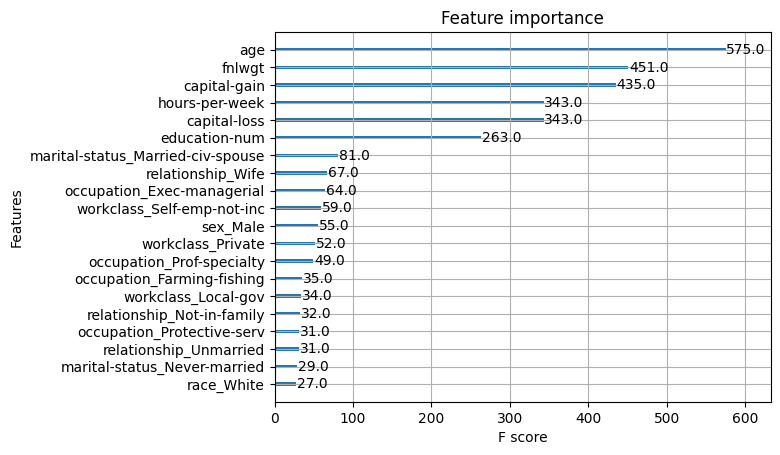

In [6]:
# DMatrix for the whole adult_train data set
X = train_df.drop("income", axis=1)
y = train_df["income"]
dtrain = xgb.DMatrix(X, label=y)

# Standard parameters for model training
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 6,
    "eta": 0.1,
}
bst = xgb.train(params, dtrain, num_boost_round=100)

# Plotting the Feature Importance to see which features are valuable and which can be discarded
xgb.plot_importance(bst, max_num_features=20)


In [7]:
# Removing columns which aren't necessary as seen in the plot above
important_features = ["age", "hours-per-week", "capital-gain", "capital-loss", "education-num"]
X_reduced = train_df[important_features]
dtrain_reduced = xgb.DMatrix(X_reduced, label=y)


<div class="alert alert-block alert-info">
    Originally, GridSearchCV was part of the code to get the best parameters. But at the moment (12th January 2025) the current version of scikit-learn has issues with
    the tag-function which causes errors in XGBoost.
    The first try was to uninstall scikit-learn and install an older version. Then the plan was to install a compatible older version of XGBoost. <br>
    Unfortunately the Flower-Framework needs a version on XGBoost greater than 2.0.0, so downgrading was not possible.<br>
    Eventually as a solution a manual gridsearch was implemented as shown down below.
</div>

In [ ]:
!pip uninstall -y scikit-learn

In [ ]:
!pip install scikit-learn==1.3.1

In [ ]:
!python -c "import sklearn; print(sklearn.__version__)"


In [ ]:
!pip freeze | grep xgboost

In [ ]:
!python --version

### Problem description:

<div class="alert alert-block alert-danger">
    File ~/miniconda3/envs/firsthandson/lib/python3.9/site-packages/sklearn/base.py:540, in ClassifierMixin.__sklearn_tags__(self)<br>
        539 def __sklearn_tags__(self):<br>
    --> 540     tags = super().__sklearn_tags__()<br>
        541     tags.estimator_type = "classifier"<br>
        542     tags.classifier_tags = ClassifierTags()<br>
    AttributeError: 'super' object has no attribute '__sklearn_tags__'
</div>

To be able to use the Flower Framework it is necessary to have xgboost >=2.0.0 installed. So there is no possibility to downgrade it.

>Scikit-learn version 1.6 modified the API around its "tags", and that's the cause of this error. XGBoost has made the necessary changes in PR11021, but at present that hasn't made it into a released version. You can either keep your sklearn version <1.6, or build XGBoost directly from github (or upgrade XGBoost, after a new version is released). <br> In sklearn 1.6.1, the error was downgraded to a warning (to be returned to an error in 1.7). So you may also install sklearn >=1.6.1,<1.7 and just expect DeprecationWarnings. <br> See also sklearn Issue#30479 and 1.6.1 release notes.

Source: https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags

In [ ]:
!pip uninstall -y xgboost

In [9]:
!pip install --upgrade xgboost

In [11]:
# First data is split into training and validation from the adult_train or train_df (after feature importance)
# X_reduced = Features after preprocessing
# y = income
# test_size=0.2 = 20% of the data is being used as validation set
# random_state=42 = Hardcoded value to guarantee reproducability

X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.2, random_state=42)


# The Grid-Parameter or Hyperparameter are defined with a couple of different values.
# With itertools.product all kinds of combinations of those Hyperparameters are tested.
# In sum there are 4 Hyperparameters, 1-3 has three parameters and 4. has two -> 4x3x3x3x2 = 72 combinations.
# max_depth = Max depth of trees
# learning_rate = Weight of each new tree
# n_estimators = Number of trees -> iteration steps during boosting
# subsample = Number or data which are randomly removed of each tree

param_grid = {
    "max_depth": [6, 8, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 150, 200],
    "subsample": [0.8, 1.0],
}

param_combinations = list(product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["n_estimators"],
    param_grid["subsample"]
))



# The best score is saved, means the highest AUC (area under the curve).
# Best params is also saved to get the combination of Hyperparameters of the best score.
best_score = 0
best_params = None



# The for-loop iterates over each combination of Hyperparameters.
# XGBClassifier is the model and gets the config parameters of param_grid which was defined above.
# model.predict_proba(X_val)[:, 1] returns the probability of a positive class, meaning if income is > 50K.
# ROC_AUC_SCORE calculates the AUC of the model.
# If AUC of the latest run has a better score than the values in best_score, the AUC values overwrite the best_score to show the best outcome.
for max_depth, learning_rate, n_estimators, subsample in param_combinations:
    model = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        eval_metric="auc",
        use_label_encoder=False,
    )
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    
    print(f"Params: max_depth={max_depth}, learning_rate={learning_rate}, n_estimators={n_estimators}, subsample={subsample}, AUC={auc}")
    
    if auc > best_score:
        best_score = auc
        best_params = {
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "n_estimators": n_estimators,
            "subsample": subsample,
        }

print("Best Parameters:", best_params)
print("Best AUC:", best_score)


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.01, n_estimators=100, subsample=0.8, AUC=0.8653722454823503
Params: max_depth=6, learning_rate=0.01, n_estimators=100, subsample=1.0, AUC=0.8639153068014171


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.01, n_estimators=150, subsample=0.8, AUC=0.8672070234967507


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.01, n_estimators=150, subsample=1.0, AUC=0.8661548436722764


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.01, n_estimators=200, subsample=0.8, AUC=0.8693503456131868


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.01, n_estimators=200, subsample=1.0, AUC=0.8681685270332549
Params: max_depth=6, learning_rate=0.1, n_estimators=100, subsample=0.8, AUC=0.8807898548689947


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.1, n_estimators=100, subsample=1.0, AUC=0.8820515304070824


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.1, n_estimators=150, subsample=0.8, AUC=0.880992588501474


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.1, n_estimators=150, subsample=1.0, AUC=0.882552954823373


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.1, n_estimators=200, subsample=0.8, AUC=0.8806332321897731


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.1, n_estimators=200, subsample=1.0, AUC=0.8825474807576932
Params: max_depth=6, learning_rate=0.2, n_estimators=100, subsample=0.8, AUC=0.8780981601729649


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.2, n_estimators=100, subsample=1.0, AUC=0.8826742858791516


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.2, n_estimators=150, subsample=0.8, AUC=0.8774399842759074


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.2, n_estimators=150, subsample=1.0, AUC=0.8816132831488165


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.2, n_estimators=200, subsample=0.8, AUC=0.8747323825890192


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=6, learning_rate=0.2, n_estimators=200, subsample=1.0, AUC=0.8799456251395887


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.01, n_estimators=100, subsample=0.8, AUC=0.8676308449819304


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.01, n_estimators=100, subsample=1.0, AUC=0.8673506372198856


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.01, n_estimators=150, subsample=0.8, AUC=0.8709498032041187


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.01, n_estimators=150, subsample=1.0, AUC=0.870618525629318


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.01, n_estimators=200, subsample=0.8, AUC=0.873303329442668


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.01, n_estimators=200, subsample=1.0, AUC=0.8717500472057664
Params: max_depth=8, learning_rate=0.1, n_estimators=100, subsample=0.8, AUC=0.8795727446656196


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.1, n_estimators=100, subsample=1.0, AUC=0.8810410822833217


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.1, n_estimators=150, subsample=0.8, AUC=0.8781708686453504


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.1, n_estimators=150, subsample=1.0, AUC=0.8813136263534143


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.1, n_estimators=200, subsample=0.8, AUC=0.8759666877987069


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.1, n_estimators=200, subsample=1.0, AUC=0.881101941013529


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.2, n_estimators=100, subsample=0.8, AUC=0.873570335046308
Params: max_depth=8, learning_rate=0.2, n_estimators=100, subsample=1.0, AUC=0.8808856188180089


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.2, n_estimators=150, subsample=0.8, AUC=0.8692266317288181


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.2, n_estimators=150, subsample=1.0, AUC=0.8793220324574742


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.2, n_estimators=200, subsample=0.8, AUC=0.865833741419563


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=8, learning_rate=0.2, n_estimators=200, subsample=1.0, AUC=0.8770398622750836


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.01, n_estimators=100, subsample=0.8, AUC=0.8674690702408924


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.01, n_estimators=100, subsample=1.0, AUC=0.8656707430638436


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.01, n_estimators=150, subsample=0.8, AUC=0.870485022827498


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.01, n_estimators=150, subsample=1.0, AUC=0.8684617437513864


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.01, n_estimators=200, subsample=0.8, AUC=0.8724876292555709


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.01, n_estimators=200, subsample=1.0, AUC=0.8698133227681719


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.1, n_estimators=100, subsample=0.8, AUC=0.8768061518709327


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.1, n_estimators=100, subsample=1.0, AUC=0.879124386486039


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.1, n_estimators=150, subsample=0.8, AUC=0.8730868140448296


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.1, n_estimators=150, subsample=1.0, AUC=0.8777879416508391


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.1, n_estimators=200, subsample=0.8, AUC=0.8695249361079933


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.1, n_estimators=200, subsample=1.0, AUC=0.8774614297332185


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.2, n_estimators=100, subsample=0.8, AUC=0.868126151324814


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.2, n_estimators=100, subsample=1.0, AUC=0.877636277831116


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.2, n_estimators=150, subsample=0.8, AUC=0.8620945037546939


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.2, n_estimators=150, subsample=1.0, AUC=0.8766705238436134


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.2, n_estimators=200, subsample=0.8, AUC=0.8570874724783298


/Users/annina/miniconda3/envs/firsthandson/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: max_depth=10, learning_rate=0.2, n_estimators=200, subsample=1.0, AUC=0.8750677174125006
Best Parameters: {'max_depth': 6, 'learning_rate': 0.2, 'n_estimators': 100, 'subsample': 1.0}
Best AUC: 0.8826742858791516


In [12]:
joblib.dump(best_params, "baseline_xgboost_model.pkl")

['baseline_xgboost_model.pkl']

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print("Train Shape:", X_train.shape, y_train.shape)
print("Validation Shape:", X_val.shape, y_val.shape)
print("Test Shape:", X_test.shape, y_test.shape)


In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
X_reduced_full = train_df[important_features]
columns = X_reduced_full.columns


In [ ]:
X_train = pd.DataFrame(X_train, columns=columns)
X_val = pd.DataFrame(X_val, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)


In [ ]:
type(X_train)
type(X_val)
type(X_test)

In [ ]:
# XGBoost expects a list of strings for feature_names, therefore we need to put them in a list() to get the feature names for the plot
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X_train.columns))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(X_val.columns))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(X_test.columns))

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.1004,
    "subsample": 1.0,
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=10
)

y_test_preds = bst.predict(dtest)
auc_test = roc_auc_score(y_test, y_test_preds)
print("Test AUC:", auc_test)


In [ ]:
xgb.plot_importance(bst, max_num_features=10)
plt.show()


### Results of plotting Feature Importance:

As shown in the plot, the following features are the most important for the model to determine if someone makes more or less than 50K per year:
- **age**: Age often correlates with experience and income.
- **hours-per-week**: More hours per week often seems to result in higher income.
- **capital-gain (and capital-loss)**: Capital gains or losses are often strong indicators of the financial situation of an individual.
- **education-num**: Higher education is a typical indicator of higher income and wealth.

<hr>

In [ ]:
auc_test = roc_auc_score(y_test, y_test_preds)
print("Test AUC:", auc_test)

<hr>

### Documenting with WandB.ai

In [ ]:
wandb.init(
    project="global-model-xgboost",
    config={
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_depth": 8,
        "learning_rate": 0.1004,
        "subsample": 1.0,
    }
)

config = wandb.config

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X_train.columns))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(X_val.columns))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(X_test.columns))

params = {
    "objective": config.objective,
    "eval_metric": config.eval_metric,
    "max_depth": config.max_depth,
    "learning_rate": config.learning_rate,
    "subsample": config.subsample,
}

num_boost_round = 200
early_stopping_rounds = 10

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=1
)


y_test_preds = bst.predict(dtest)
auc_test = roc_auc_score(y_test, y_test_preds)
print("Test AUC:", auc_test)

wandb.log({"Test AUC": auc_test})

plt.savefig("feature_importance.png")
wandb.log({"Feature Importance": wandb.Image("feature_importance.png")})

bst.save_model("global_model.json")
wandb.save("global_model.json")

wandb.finish()
